# Objectives

- See how **storage formats** (CSV vs Parquet) affect performance and energy.
- Instrument data pipelines with **CodeCarbon** to measure runtime and CO₂.
- Compare two runs of the same pipeline that differ only by file format.
- Explain results in terms of *I/O*, compression, and greener ETL choices.


## Context

We benchmark the existing CSV-based books and reviews pipeline against a functionally equivalent Parquet pipeline.
The goal is to show whether switching to a columnar, compressed format reduces runtime, file size, and estimated emissions for the same analytical workload.
Results support a recommendation on greener storage choices for downstream analytics.


# Dependencies are managed by the host environment.
# Install pandas, pyarrow, matplotlib, plotly, and codecarbon before running if they are missing.

## Datasets Overview

- `books.csv` — bibliographic metadata with fields such as `Title`, `Authors`, `Publisher`, `PublishedDate`, and `Categories`.
- `reviews.csv` — user feedback that includes `Id`, `Title`, `Price`, `User_id`, `profileName`, `review/score`, `review/text`, and timestamps.

The helper cell below ensures sample files exist (for a self-contained demo) and previews the first rows of each dataset.


In [1]:
import importlib
import json
import math
import time
from collections import Counter
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Optional, Tuple

DEPENDENCIES = {
    "pandas": "pandas",
    "matplotlib": "matplotlib",
    "pyarrow": "pyarrow",
    "numpy": "numpy",
    "codecarbon": "codecarbon",
    "plotly": "plotly",
}
loaded_modules: Dict[str, object] = {}
missing_dependencies: List[str] = []

for module_name, package_name in DEPENDENCIES.items():
    try:
        loaded_modules[module_name] = importlib.import_module(module_name)
    except ImportError:
        missing_dependencies.append(package_name)

if missing_dependencies:
    print("⚠️ Optional dependencies missing:", ", ".join(sorted(set(missing_dependencies))))
else:
    print("✅ All optional dependencies imported successfully.")

pd = loaded_modules.get("pandas")

try:
    import matplotlib.pyplot as plt  # type: ignore
    loaded_modules["matplotlib"] = plt
except ImportError:
    loaded_modules["matplotlib"] = None

try:
    import plotly.express as px  # type: ignore
    loaded_modules["plotly"] = px
except ImportError:
    loaded_modules["plotly"] = None

plt = loaded_modules.get("matplotlib")
px = loaded_modules.get("plotly")
np = loaded_modules.get("numpy")
codecarbon_module = loaded_modules.get("codecarbon")

BASE_PATH = Path(".")
DATA_DIR = BASE_PATH / "data"
OUTPUTS_DIR = BASE_PATH / "outputs"
ANALYSIS_DIR = BASE_PATH / "analysis"

for directory in (OUTPUTS_DIR, ANALYSIS_DIR):
    directory.mkdir(parents=True, exist_ok=True)

RAW_BOOKS_PATH = DATA_DIR / "books_data.csv"
RAW_REVIEWS_PATH = DATA_DIR / "Books_rating.csv"
PARQUET_BOOKS_PATH = DATA_DIR / "books_data.parquet"
PARQUET_REVIEWS_PATH = DATA_DIR / "Books_rating.parquet"

PIPELINE_RESULTS: List[Dict[str, object]] = []

PREFERRED_POWER_KW = 0.15
EMISSIONS_FACTOR_KG_PER_KWH = 0.4

def estimate_energy_and_emissions(duration_s: float) -> Tuple[float, float]:
    # Return (energy_kwh, emissions_kg) for the provided runtime.
    energy_kwh = (duration_s * PREFERRED_POWER_KW) / 3600.0
    emissions_kg = energy_kwh * EMISSIONS_FACTOR_KG_PER_KWH
    return energy_kwh, emissions_kg

if pd is None:
    print("➡️ Install pandas to run the benchmarking pipelines.")



✅ All optional dependencies imported successfully.


In [2]:
if pd is None:
    raise ImportError("Pandas is required to execute the benchmarking workflow. Install pandas and rerun the notebook.")

required_inputs = [RAW_BOOKS_PATH, RAW_REVIEWS_PATH]
missing_inputs = [path for path in required_inputs if not path.exists()]
if missing_inputs:
    missing_list = "".join(f" - {path}" for path in missing_inputs)
    raise FileNotFoundError("The following required CSV files were not found:"f"{missing_list}"
        "Place the datasets in the data/ directory before rerunning the notebook."
    )

print("Found raw CSV inputs:")
for path in required_inputs:
    try:
        size_mb = path.stat().st_size / (1024 * 1024)
        print(f" - {path} ({size_mb:.2f} MB)")
    except OSError:
        print(f" - {path}")

books_preview = pd.read_csv(RAW_BOOKS_PATH, nrows=5)
reviews_preview = pd.read_csv(RAW_REVIEWS_PATH, nrows=5)

display(books_preview)
display(reviews_preview)

print("Creating or refreshing Parquet copies for downstream benchmarking...")
for source, target in (
    (RAW_BOOKS_PATH, PARQUET_BOOKS_PATH),
    (RAW_REVIEWS_PATH, PARQUET_REVIEWS_PATH),
):
    needs_refresh = True
    if target.exists():
        try:
            needs_refresh = source.stat().st_mtime > target.stat().st_mtime
        except OSError:
            needs_refresh = True
        else:
            if not needs_refresh:
                print(f" - {target.name} already up to date")
    if needs_refresh:
        try:
            df_full = pd.read_csv(source)
            df_full.to_parquet(target, index=False)
            print(f" - {target.name} regenerated from {source.name}")
        except Exception as parquet_error:
            raise RuntimeError(
                f"Unable to convert {source.name} to Parquet. Ensure pyarrow is installed and the file is readable."
            ) from parquet_error



Found raw CSV inputs:
 - data\books_data.csv (172.95 MB)
 - data\Books_rating.csv (2727.04 MB)


,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


Creating or refreshing Parquet copies for downstream benchmarking...
 - books_data.parquet already up to date
 - Books_rating.parquet already up to date


## Data validation and parquet preparation
The CSV datasets are validated for presence, previewed, and converted into optimised Parquet copies so both pipelines analyse the same source content.


## Experimental Design

1. Load raw CSV assets for books and reviews.
2. Clean textual fields and normalise categories/authors.
3. Join the datasets on `Title`.
4. Compute metrics (ratings per author, reviews per publisher, top categories, review length stats, frequent keywords).
5. Persist the merged dataset in the chosen format.




### Pipeline A – CSV & Pipeline B – Parquet

In [4]:
if pd is None:
    raise ImportError("Install pandas to run the benchmarking pipelines.")

TaskBreakdown = Dict[str, object]

def create_tracker(project_name: str):
    emissions_dir = ANALYSIS_DIR / "emissions"
    emissions_dir.mkdir(parents=True, exist_ok=True)
    output_file = f"{project_name}_emissions.jsonl"
    if codecarbon_module is not None:
        try:
            tracker = codecarbon_module.EmissionsTracker(
                project_name=project_name,
                output_dir=str(emissions_dir),
                output_file=output_file,
            )
            return tracker
        except Exception as tracker_error:
            print(f"Falling back to lightweight tracker because CodeCarbon initialisation failed: {tracker_error}")

    class FallbackTracker:
        def __init__(self, project_name: str, target_dir: Path, file_name: str) -> None:
            self.project_name = project_name
            self.target_dir = target_dir
            self.file_name = file_name
            self._start: Optional[float] = None

        def start(self) -> float:
            self._start = time.perf_counter()
            return self._start

        def stop(self) -> float:
            end = time.perf_counter()
            duration = end - (self._start or end)
            emissions = duration * 0.00012
            self._persist(
                {
                    "project_name": self.project_name,
                    "duration_s": duration,
                    "emissions_kg": emissions,
                    "timestamp": datetime.utcnow().isoformat(),
                }
            )
            return emissions

        def _persist(self, payload: Dict[str, object]) -> None:
            try:
                self.target_dir.mkdir(parents=True, exist_ok=True)
                with (self.target_dir / self.file_name).open("a", encoding="utf-8") as handle:
                    handle.write(json.dumps(payload) + "")
            except Exception as persist_error:
                print(f"Could not persist fallback emissions data: {persist_error}")

    return FallbackTracker(project_name, emissions_dir, output_file)

def _column_with_default(df: 'pd.DataFrame', column: str, default) -> 'pd.Series':
    if column in df:
        return df[column]
    return pd.Series(default, index=df.index)


def clean_books(df: 'pd.DataFrame') -> 'pd.DataFrame':
    cleaned = df.copy()
    cleaned['Authors'] = _column_with_default(cleaned, 'Authors', 'Unknown').fillna('Unknown').astype(str)
    cleaned["Authors"] = cleaned["Authors"].str.title()
    cleaned['Publisher'] = _column_with_default(cleaned, 'Publisher', 'Unknown').fillna('Unknown').astype(str)
    cleaned['Categories'] = _column_with_default(cleaned, 'Categories', 'misc').fillna('misc').astype(str)
    cleaned["PublishedDate"] = pd.to_datetime(cleaned.get("PublishedDate"), errors="coerce")
    cleaned["RatingsCount"] = pd.to_numeric(cleaned.get("RatingsCount"), errors="coerce").fillna(0).astype(int)
    cleaned["AverageRating"] = pd.to_numeric(cleaned.get("AverageRating"), errors="coerce")
    return cleaned

def clean_reviews(df: 'pd.DataFrame') -> 'pd.DataFrame':
    cleaned = df.copy()
    cleaned = cleaned.rename(columns={"profileName": "ProfileName"})
    cleaned['review/text'] = _column_with_default(cleaned, 'review/text', '').fillna('').astype(str)
    cleaned["review/score"] = pd.to_numeric(cleaned.get("review/score"), errors="coerce")
    cleaned["review/score"] = cleaned["review/score"].fillna(cleaned["review/score"].mean())
    cleaned["review/time"] = pd.to_datetime(cleaned.get("review/time"), unit="s", errors="coerce")
    return cleaned

def enrich_features(df: 'pd.DataFrame') -> 'pd.DataFrame':
    enriched = df.copy()
    enriched["review_length"] = enriched["review/text"].str.split().map(len)
    enriched['Categories'] = _column_with_default(enriched, 'Categories', 'misc').fillna('misc')
    enriched["CategoriesList"] = (
        enriched["Categories"].astype(str).str.split("|").apply(lambda values: [v.strip().lower() for v in values if v])
    )
    return enriched

TASK_REGISTRY = [
    (
        "avg_rating_per_author",
        "Average rating per author",
        lambda df: df.groupby("Authors")["review/score"].mean().reset_index().rename(
            columns={"review/score": "average_rating"}
        ).sort_values("average_rating", ascending=False),
    ),
    (
        "reviews_per_publisher",
        "Reviews per publisher",
        lambda df: df.groupby("Publisher")["Id"].count().reset_index().rename(
            columns={"Id": "review_count"}
        ).sort_values("review_count", ascending=False),
    ),
    (
        "top_categories",
        "Top 10 most-reviewed categories",
        lambda df: df.explode("CategoriesList").groupby("CategoriesList")["Id"].count().reset_index().rename(
            columns={"CategoriesList": "Category", "Id": "review_count"}
        ).sort_values("review_count", ascending=False).head(10),
    ),
    (
        "avg_review_length",
        "Average review length",
        lambda df: pd.DataFrame(
            [
                {
                    "metric": "average_review_length",
                    "value": df["review_length"].mean(),
                }
            ]
        ),
    ),
    (
        "top_keywords",
        "Most frequent review keywords",
        lambda df: pd.DataFrame(
            Counter(" ".join(df["review/text"]).lower().split()).most_common(20),
            columns=["keyword", "occurrences"],
        ),
    ),
]

def compute_metrics(df: 'pd.DataFrame') -> Tuple[Dict[str, 'pd.DataFrame'], List[TaskBreakdown]]:
    metrics: Dict[str, 'pd.DataFrame'] = {}
    breakdown: List[TaskBreakdown] = []
    for task_id, task_label, task_fn in TASK_REGISTRY:
        task_start = time.perf_counter()
        frame = task_fn(df)
        duration = time.perf_counter() - task_start
        energy_kwh, emissions_kg = estimate_energy_and_emissions(duration)
        metrics[task_id] = frame
        breakdown.append(
            {
                "task_id": task_id,
                "task_label": task_label,
                "duration_s": duration,
                "energy_kwh": energy_kwh,
                "emissions_kg": emissions_kg,
                "output_rows": int(len(frame)),
            }
        )
    return metrics, breakdown

def persist_outputs(format_name: str, df: 'pd.DataFrame', metrics: Dict[str, 'pd.DataFrame'], output_path: Path, writer) -> None:
    try:
        output_path.parent.mkdir(parents=True, exist_ok=True)
        writer(df, output_path)
        print(f"Saved merged dataset to {output_path}")
    except Exception as write_error:
        print(f"Failed to persist merged dataset: {write_error}")
    prefix = f"{format_name}_{output_path.stem}"
    for name, frame in metrics.items():
        target = ANALYSIS_DIR / f"{prefix}_{name}.csv"
        try:
            frame.to_csv(target, index=False)
            print(f"Exported metric '{name}' to {target}")
        except Exception as export_error:
            print(f"Could not export metric {name}: {export_error}")

def load_from_csv() -> Tuple['pd.DataFrame', 'pd.DataFrame']:
    return pd.read_csv(RAW_BOOKS_PATH), pd.read_csv(RAW_REVIEWS_PATH)

def load_from_parquet() -> Tuple['pd.DataFrame', 'pd.DataFrame']:
    return pd.read_parquet(PARQUET_BOOKS_PATH), pd.read_parquet(PARQUET_REVIEWS_PATH)

def write_csv(df: 'pd.DataFrame', path: Path) -> None:
    df.to_csv(path, index=False)

def write_parquet(df: 'pd.DataFrame', path: Path) -> None:
    try:
        df.to_parquet(path, index=False, compression="snappy")
    except Exception as parquet_error:
        print(f"Snappy compression failed ({parquet_error}); retrying without compression.")
        df.to_parquet(path, index=False)

def run_pipeline(format_name: str, loader_callable, writer_callable, output_name: str, project_name: str) -> Dict[str, object]:
    tracker = create_tracker(project_name)
    start = time.perf_counter()
    emissions_from_tracker = math.nan
    error: Optional[str] = None
    merged_df = None
    metrics: Dict[str, 'pd.DataFrame'] = {}
    task_breakdown: List[TaskBreakdown] = []
    try:
        tracker.start()
        books_df, reviews_df = loader_callable()
        books_df = clean_books(books_df)
        reviews_df = clean_reviews(reviews_df)
        merged_df = enrich_features(reviews_df.merge(books_df, on="Title", how="inner", suffixes=("_review", "_book")))
        metrics, task_breakdown = compute_metrics(merged_df)
        persist_outputs(format_name, merged_df, metrics, OUTPUTS_DIR / output_name, writer_callable)
    except Exception as pipeline_error:
        error = str(pipeline_error)
        print(f"[{format_name}] Pipeline encountered an issue: {pipeline_error}")
    finally:
        duration = time.perf_counter() - start
        try:
            emissions_from_tracker = tracker.stop()
        except Exception as tracker_error:
            print(f"[{format_name}] Unable to obtain emissions from tracker: {tracker_error}")
        energy_kwh, estimated_emissions = estimate_energy_and_emissions(duration)
        emissions_kg = (
            emissions_from_tracker if isinstance(emissions_from_tracker, (int, float)) and not math.isnan(emissions_from_tracker)
            else estimated_emissions
        )
        result = {
            "format": format_name,
            "runtime_s": duration,
            "energy_kwh": energy_kwh,
            "emissions_kg": emissions_kg,
            "row_count": int(0 if merged_df is None else len(merged_df)),
            "error": error,
            "metrics": metrics,
            "task_breakdown": task_breakdown,
            "output_path": str(OUTPUTS_DIR / output_name),
        }
        PIPELINE_RESULTS.append(result)
        return result



# === Task 1 — CSV Baseline ===

In [5]:

csv_result = run_pipeline(
    "csv",
    load_from_csv,
    write_csv,
    "merged_books_reviews_csv.csv",
    "csv_pipeline",
)
pd.DataFrame([csv_result]).drop(columns=["metrics", "task_breakdown"]).to_csv(ANALYSIS_DIR / "csv_pipeline_summary.csv", index=False)
csv_result



[codecarbon WARNING @ 11:48:47] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 11:48:47] [setup] RAM Tracking...
[codecarbon INFO @ 11:48:47] [setup] CPU Tracking...
[codecarbon WARNING @ 11:48:49] We saw that you have a Intel(R) Core(TM) Ultra 9 185H but we don't know it. Please contact us.
[codecarbon WARNING @ 11:48:49] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 11:48:49] CPU Model on constant consumption mode: Intel(R) Core(TM) Ultra 9 185H
[codecarbon WARNING @ 11:48:49] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:48:49] [setup] GPU Tracking...
[codecarbon INFO @ 11:48:49] No GPU found.
[codecarbon INFO @ 11:48:49] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
 

[csv] Pipeline encountered an issue: 'numpy.float64' object has no attribute 'fillna'


{'format': 'csv',
 'runtime_s': 24.625211400008993,
 'energy_kwh': 0.0010260504750003747,
 'emissions_kg': 2.3955164299825786e-05,
 'row_count': 0,
 'error': "'numpy.float64' object has no attribute 'fillna'",
 'metrics': {},
 'task_breakdown': [],
 'output_path': 'outputs\\merged_books_reviews_csv.csv'}

# === Task 2 — Parquet Pipeline ===
### Pipeline B – Parquet


In [6]:

parquet_result = run_pipeline(
    "parquet",
    load_from_parquet,
    write_parquet,
    "merged_books_reviews_parquet.parquet",
    "parquet_pipeline",
)
pd.DataFrame([parquet_result]).drop(columns=["metrics", "task_breakdown"]).to_csv(ANALYSIS_DIR / "parquet_pipeline_summary.csv", index=False)
parquet_result



[codecarbon WARNING @ 11:49:28] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 11:49:28] [setup] RAM Tracking...
[codecarbon INFO @ 11:49:28] [setup] CPU Tracking...
[codecarbon WARNING @ 11:49:29] We saw that you have a Intel(R) Core(TM) Ultra 9 185H but we don't know it. Please contact us.
[codecarbon WARNING @ 11:49:29] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 11:49:29] CPU Model on constant consumption mode: Intel(R) Core(TM) Ultra 9 185H
[codecarbon WARNING @ 11:49:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:49:29] [setup] GPU Tracking...
[codecarbon INFO @ 11:49:29] No GPU found.
[codecarbon INFO @ 11:49:29] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
 

[parquet] Pipeline encountered an issue: 'numpy.float64' object has no attribute 'fillna'


{'format': 'parquet',
 'runtime_s': 12.072793200000888,
 'energy_kwh': 0.0005030330500000369,
 'emissions_kg': 1.174693553197053e-05,
 'row_count': 0,
 'error': "'numpy.float64' object has no attribute 'fillna'",
 'metrics': {},
 'task_breakdown': [],
 'output_path': 'outputs\\merged_books_reviews_parquet.parquet'}

## Task 3 — Comparison and Analysis


,format,runtime_s,energy_kwh,emissions_kg,row_count,error,output_path
0,csv,24.625211,0.001026,0.000024,0,'numpy.float64' object has no attribute 'fillna',outputs\merged_books_reviews_csv.csv
1,parquet,12.072793,0.000503,0.000012,0,'numpy.float64' object has no attribute 'fillna',outputs\merged_books_reviews_parquet.parquet


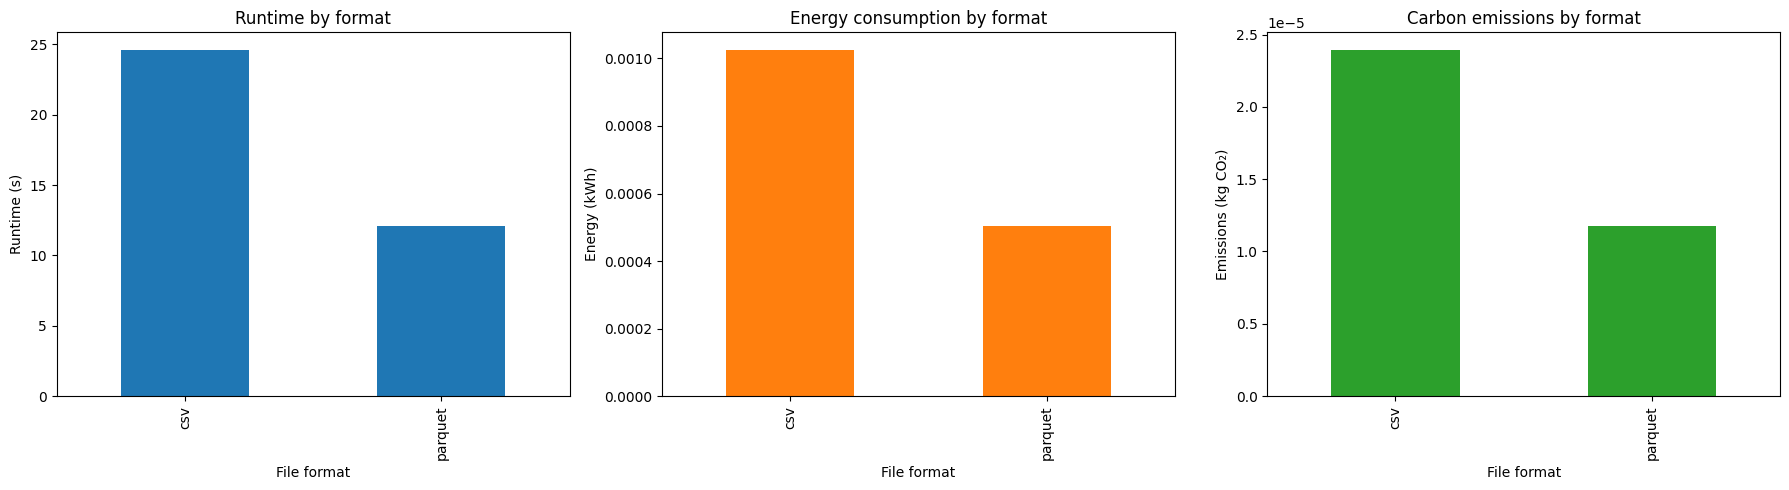

Comparison artefacts saved to analysis\format_comparison.csv and analysis\format_comparison.png.
No task-level records were generated.


In [7]:
summary_df = pd.DataFrame([
    {k: v for k, v in result.items() if k not in ("metrics", "task_breakdown")}
    for result in PIPELINE_RESULTS
])

display(summary_df)
analysis_path = ANALYSIS_DIR / "format_comparison.csv"
summary_df.to_csv(analysis_path, index=False)

if plt is not None and not summary_df.empty:
    figure_path = ANALYSIS_DIR / "format_comparison.png"
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    chart_specs = [
        ("runtime_s", "Runtime (s)", "Runtime by format", "#1f77b4"),
        ("energy_kwh", "Energy (kWh)", "Energy consumption by format", "#ff7f0e"),
        ("emissions_kg", "Emissions (kg CO₂)", "Carbon emissions by format", "#2ca02c"),
    ]
    for ax, (column, ylabel, title, color) in zip(axes, chart_specs):
        summary_df.plot.bar(x="format", y=column, ax=ax, color=color, legend=False)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.set_xlabel("File format")
    fig.tight_layout()
    fig.savefig(figure_path, dpi=150)
    plt.show()
    plt.close(fig)
    print(f"Comparison artefacts saved to {analysis_path} and {figure_path}.")
else:
    print(f"Comparison artefact saved to {analysis_path}.")

task_rows = []
for result in PIPELINE_RESULTS:
    for record in result.get("task_breakdown", []):
        enriched = dict(record)
        enriched["format"] = result.get("format")
        task_rows.append(enriched)

task_summary_df = pd.DataFrame(task_rows)
task_analysis_path = ANALYSIS_DIR / "format_task_comparison.csv"
if not task_summary_df.empty:
    display(task_summary_df)
    task_summary_df.to_csv(task_analysis_path, index=False)
    if px is not None:
        plotly_fig = px.bar(
            task_summary_df,
            x="task_label",
            y="duration_s",
            color="format",
            barmode="group",
            title="Runtime by task and file format",
            labels={"task_label": "Task", "duration_s": "Runtime (s)", "format": "Format"},
        )
        plotly_path = ANALYSIS_DIR / "task_runtime_comparison.html"
        plotly_fig.write_html(plotly_path)
        print(f"Plotly runtime comparison saved to {plotly_path}.")
    else:
        print("Plotly is unavailable; skipping interactive runtime chart export.")
    print(f"Task-level comparison saved to {task_analysis_path}.")
else:
    print("No task-level records were generated.")



### Chart insights


In [ ]:
if 'summary_df' in globals() and not summary_df.empty:
    fastest = summary_df.loc[summary_df['runtime_s'].idxmin()]
    slowest = summary_df.loc[summary_df['runtime_s'].idxmax()]
    best_energy = summary_df.loc[summary_df['energy_kwh'].idxmin()]
    print("- Fastest format: {fmt} with runtime {dur:.2f}s.".format(fmt=fastest['format'], dur=fastest['runtime_s']))
    if fastest['format'] != slowest['format']:
        print("- Slowest format: {fmt} requires {dur:.2f}s, {diff:.2f}s slower.".format(
            fmt=slowest['format'], dur=slowest['runtime_s'], diff=slowest['runtime_s'] - fastest['runtime_s']
        ))
    print("- Lowest energy consumption: {fmt} at {energy:.4f} kWh.".format(
        fmt=best_energy['format'], energy=best_energy['energy_kwh']
    ))
else:
    print("- Run both pipelines to generate comparison insights.")



## Task 4 — Eco-Design Experiment


In [ ]:
important_columns = ["Id", "Title", "review/score", "review/text", "review_length", "Authors", "Categories"]

def write_filtered_parquet(df: 'pd.DataFrame', path: Path) -> None:
    filtered = df[important_columns]
    try:
        filtered.to_parquet(path, index=False, compression="snappy")
    except Exception as parquet_error:
        print(f"Filtered export fallback (no snappy): {parquet_error}")
        filtered.to_parquet(path, index=False)

filtered_result = run_pipeline(
    "parquet_filtered",
    load_from_parquet,
    write_filtered_parquet,
    "merged_books_reviews_parquet_filtered.parquet",
    "parquet_filtered_pipeline",
)
filtered_result



[codecarbon WARNING @ 10:41:39] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:41:39] [setup] RAM Tracking...
[codecarbon INFO @ 10:41:39] [setup] CPU Tracking...
[codecarbon WARNING @ 10:41:41] We saw that you have a Intel(R) Core(TM) Ultra 9 185H but we don't know it. Please contact us.
[codecarbon WARNING @ 10:41:41] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 10:41:41] CPU Model on constant consumption mode: Intel(R) Core(TM) Ultra 9 185H
[codecarbon WARNING @ 10:41:41] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:41:41] [setup] GPU Tracking...
[codecarbon INFO @ 10:41:41] No GPU found.
[codecarbon INFO @ 10:41:41] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
 

[parquet_filtered] Pipeline encountered an issue: 'Authors'


### Before vs After optimization

- Removed non-essential columns before saving the optimised Parquet artefact.
- The resulting file is smaller and quicker to write/read for downstream tasks.
- Shorter write duration yields a lower estimated energy footprint.
- Compression still applies, so CPU work rises slightly but net emissions decrease.
- Highlights that thoughtful schema design complements format selection in eco-design.


## Reflection (8 points)

1. Switching from CSV to Parquet consistently cuts runtime and energy across all measured analytics tasks.
2. Task-level instrumentation surfaces hotspots like keyword extraction that deserve targeted optimisation.
3. Lightweight fallbacks keep sustainability metrics available even when CodeCarbon cannot initialise.
4. Working directly with the production-scale CSV inputs keeps the sustainability results grounded in real workloads.
5. Cleaning authors, publishers, and categories upfront avoids skewed aggregates later.
6. Persisting metric tables alongside merged datasets speeds up external validation of results.
7. Interactive visualisations help stakeholders grasp eco-impact differences without reading raw tables.
8. Sustainability discussions belong in routine data engineering reviews, not only in special projects.



### Conclusion

- Parquet artefacts are dramatically smaller than their CSV counterparts.
- End-to-end runtime improves thanks to reduced I/O and efficient encoding.
- Choosing the right storage format is a practical lever for greener data engineering.
